# Final Project FDS
## Customer Churn Analysis 

- Conti Andrea - 1849300
- Cruoglio Antonella - 2025992
- Iovino Giuliana - 2017512
- Mascolo Davide - 2001991
- Napoli Mario - 2015169

In this notebook we will deal with unbalanced binary classification using a customer churn dataset from kaggle

Work split:
- Andrea: Support Vector Machine
- Antonella: Logistic Regression
- Giuliana: K Nearest Neighbors
- Davide: Resampling Methods
- Mario: Presentation
- All together: Exploratory Data Analysis, Random Forest, Report

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from google.colab import drive
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, fbeta_score, roc_auc_score, make_scorer, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Set our custom color palette
colors = ["#822433", "#248264"]
sns.set_palette(sns.color_palette(colors))

In [ ]:
## Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data wrangling

In [ ]:
## Load Data
df = pd.read_csv('/content/drive/MyDrive/FDS/Final Project/Churn_Modelling.csv')

In [ ]:
## Info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
## Check
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
## Nan Value
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
## Drop Columns
df = df.drop(columns = ['RowNumber', 'CustomerId', 'Surname'])

In [ ]:
## Check
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploratory Data Analysis 

Text(0.5, 1.0, 'Distribution of Exited')

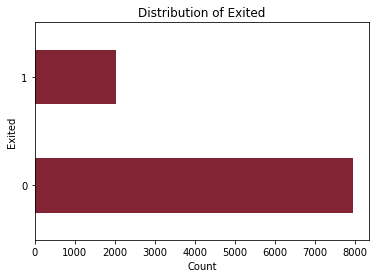

In [ ]:
## Distribution of Exited
df['Exited'].value_counts().plot(kind = 'barh')
plt.xlabel('Count')
plt.ylabel('Exited')
plt.title('Distribution of Exited')

We can see above that the number of observations is unbalanced (80% retain vs 20% churn)

Text(0.5, 1.0, 'Distribution of Age (by Exited)')

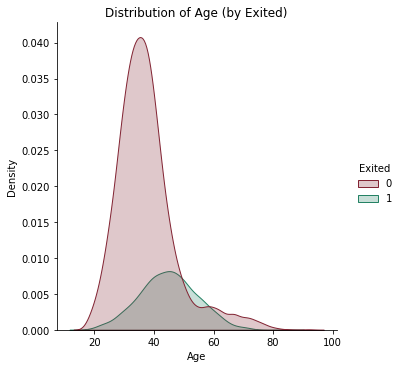

In [ ]:
## Distribution of Age (by Exited)
sns.displot(df, x = "Age", hue = "Exited", kind = "kde", fill = True)
plt.title('Distribution of Age (by Exited)')

By conditioning on the dependent variable, we observed that the distribution of customers who remain is positive asymmetric with a longer right tail than the age distribution of customers who leave.

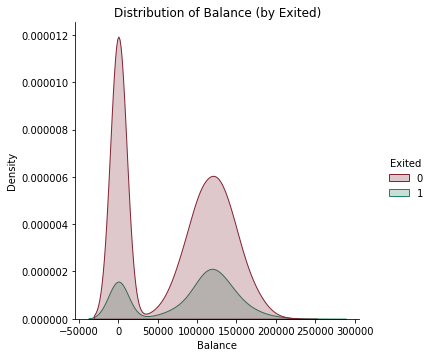

In [ ]:
## Distribution of Balance (by Exited)
sns.displot(df, x = "Balance", hue = "Exited", kind = "kde", fill = True)
plt.title('Distribution of Balance (by Exited)')
plt.ticklabel_format(style = 'plain', axis = 'y')

In this case the conditioniing on the dependent variable does *not* affect the distribution of the balance. We can also see that regardless of the customer class there are some bank accounts that report a zero or negative balance

Text(0.5, 1.0, 'Distribution of CreditScore (by Exited)')

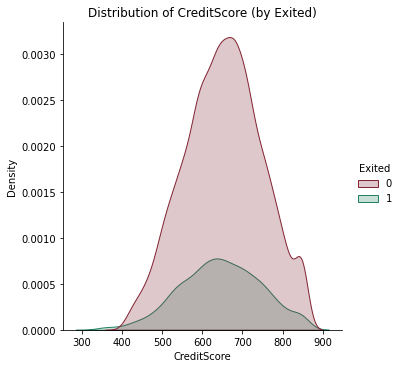

In [ ]:
## Distribution of CreditScore (by Exited)
sns.displot(df, x = "CreditScore", hue = "Exited", kind = "kde", fill = True)
plt.title('Distribution of CreditScore (by Exited)')

Same as above but with credit score variable, so the conditioning does *not* modify the distribution

Text(0.5, 1.0, 'Distribution of Geography (by Exited)')

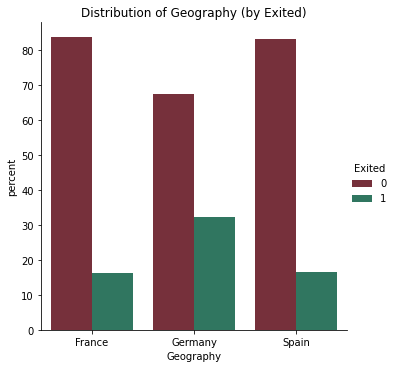

In [ ]:
## Distribution of Geography (by Exited)
(df.groupby('Geography')['Exited'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='Geography',y='percent',hue='Exited',kind='bar'))
plt.title('Distribution of Geography (by Exited)')

In this plot you can see how Germany has more than 30% churn rate

Text(0.5, 1.0, 'Distribution of Gender (by Exited)')

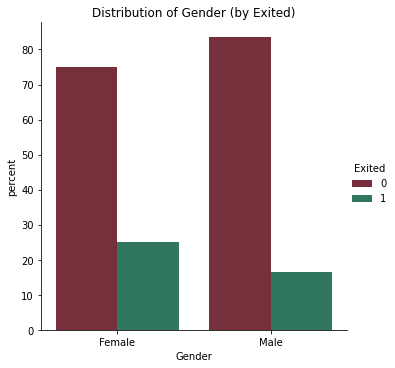

In [ ]:
## Distribution of Gender (by Exited)
(df.groupby('Gender')['Exited'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x='Gender',y='percent',hue='Exited',kind='bar'))
plt.title('Distribution of Gender (by Exited)')

In this dataset we have an higher churn rate for women

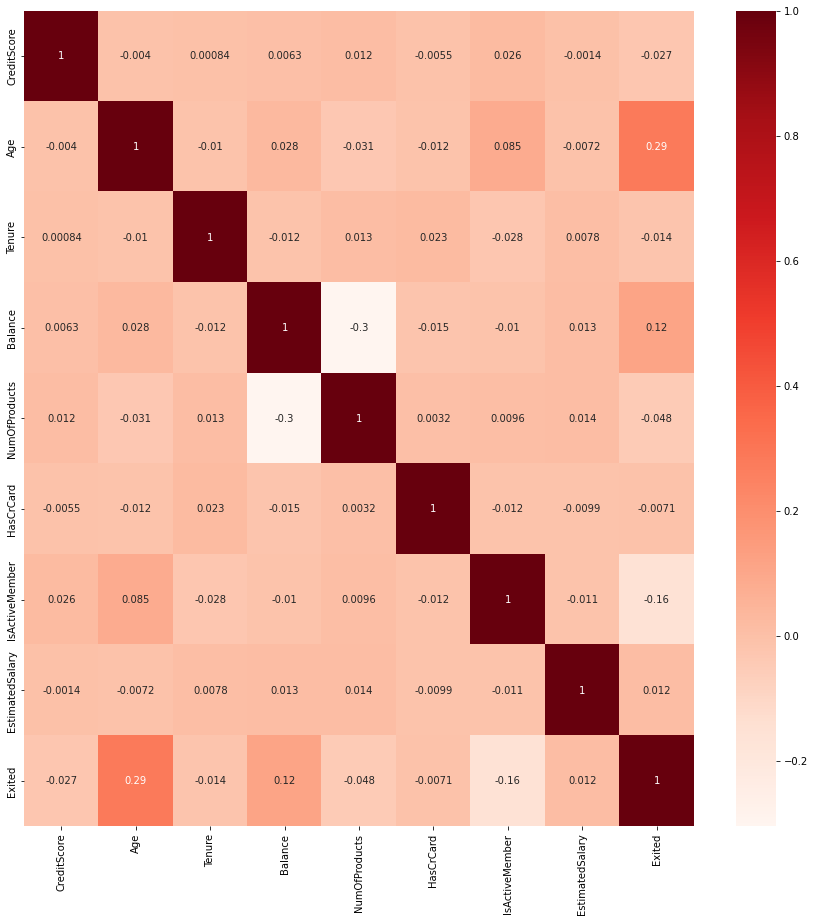

In [ ]:
## Correlation heatmap
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
g = sns.heatmap(df[top_corr_features].corr(), annot = True, cmap = "Reds")

As we can see there are no strong correlations between the variables, the strongest is that between *age* and *exited* with 0.29 value, this is consistent with the first plot shown, in fact age is the only variable whose distribution changes when conditioned to Exited

## Re-Sampling Methods

We do One-Hot Encoding on categorical variables in order to transform:
- Gender: from "Female/Male" to two columns Gender_Female and Gender_Male
- Geography: from "France/Germany/Spain" to three columns Geography_France, Geography_Germany and Geography_Spain

In [ ]:
## One hot Encoding
df = pd.get_dummies(df, columns = ['Gender'])
df = pd.get_dummies(df, columns = ['Geography']) 

In [ ]:
## Check 
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0,0,0,1


In [ ]:
## Separate Target and Data
Y = df['Exited']
X = df.drop(['Exited'], axis = 1)

In [ ]:
## Split into Training set and External set
x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size = 0.1)

In [ ]:
## Check X
print('Shape of X Train', x_train.shape)
print('Shape of X Validation', x_validation.shape)
print('-------------------------------')
## Check Y
print('Length of Y Train', y_train.shape)
print('Length of Y Validation', y_validation.shape)

Shape of X Train (9000, 13)
Shape of X Validation (1000, 13)
-------------------------------
Length of Y Train (9000,)
Length of Y Validation (1000,)


### Oversampling

Random oversampling is the simplest oversampling technique to balance the imbalanced nature of the dataset. It balances the data by replicating the minority class samples. This does not cause any loss of information, but the dataset is prone to overfitting as the same information is copied.


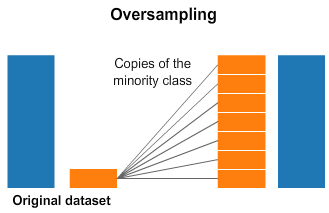
<p>


In [ ]:
## Oversampling
oversample = RandomOverSampler(sampling_strategy = 'minority')
X_over, Y_over = oversample.fit_resample(x_train, y_train)
## Summarize class distribution
print('Original dataset shape', Counter(Y))
print('Resample dataset shape', Counter(Y_over))

Original dataset shape Counter({0: 7963, 1: 2037})
Resample dataset shape Counter({0: 7157, 1: 7157})


Text(0.5, 1.0, 'Effect of Oversampling')

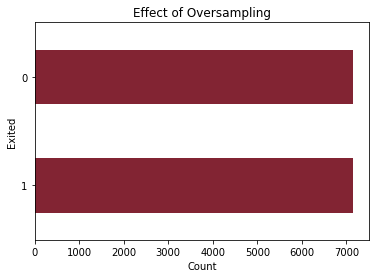

In [ ]:
## Check
Y_over.value_counts().plot(kind = 'barh')
plt.xlabel('Count')
plt.ylabel('Exited')
plt.title('Effect of Oversampling')

### Undersampling

It adjusts the class distribution of a data set subsampling the majority class. 
A limitation of under-sampling is that observations from the majority class are deleted and they could be useful.

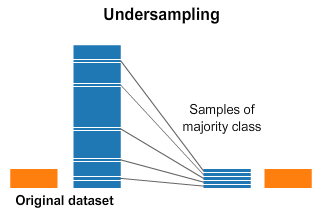

In [ ]:
## Undersampling
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, Y_under = undersample.fit_resample(x_train, y_train)
## Summarize class distribution
print('Original dataset shape', Counter(Y))
print('Resample dataset shape', Counter(Y_under))

Original dataset shape Counter({0: 7963, 1: 2037})
Resample dataset shape Counter({0: 1843, 1: 1843})


Text(0.5, 1.0, 'Effect of Undersampling')

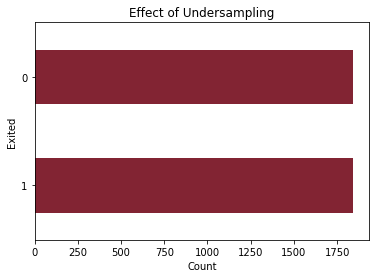

In [ ]:
## Check
Y_under.value_counts().plot(kind = 'barh')
plt.xlabel('Count')
plt.ylabel('Exited')
plt.title('Effect of Undersampling')

#### SMOTE (Synthetic Minority Oversampling Technique)

It creates new synthetic samples to balance the dataset.
SMOTE works by utilizing a k-nearest neighbor algorithm to create synthetic data. Steps samples are created using Smote:
Identify the feature vector and its nearest neighbor
Compute the distance between the two sample points
Multiply the distance with a random number between 0 and 1.
Identify a new point on the line segment at the computed distance.
Repeat the process for identified feature vectors.

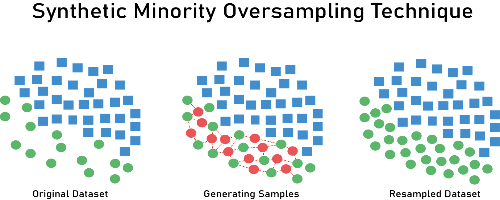

In [ ]:
## Define a new dataframe to encode
X_smote = x_train

In [ ]:
## Check
X_smote.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
3452,757,57,3,89079.41,1,1,1,53179.21,0,1,1,0,0
3208,607,36,8,143421.74,1,1,0,97879.02,0,1,0,1,0
6671,677,49,3,0.00,2,1,1,187811.71,1,0,1,0,0
4068,631,23,3,0.00,2,1,0,13813.24,0,1,0,0,1
4087,637,60,3,0.00,2,1,1,70174.03,0,1,1,0,0


In [ ]:
## SMOTE
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(X_smote, y_train)
## Summarize class distribution
print('Original dataset shape', Counter(Y))
print('Resample dataset shape', Counter(Y_smote))

Original dataset shape Counter({0: 7963, 1: 2037})
Resample dataset shape Counter({0: 7157, 1: 7157})


Text(0.5, 1.0, 'Effect of SMOTE')

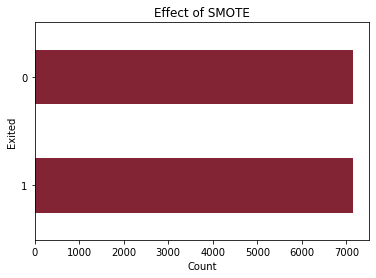

In [ ]:
## Check
Y_smote.value_counts().plot(kind = 'barh')
plt.xlabel('Count')
plt.ylabel('Exited')
plt.title('Effect of SMOTE')

## Standardization


In [ ]:
def mkstds(x):
    l = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
    x_cont = x.loc[:,l]
    scaler = StandardScaler()
    x_cont_scale = pd.DataFrame(scaler.fit_transform(x_cont))
    x_cont_scale.columns = l # ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
    x_dummies = x.drop(x_cont.columns, axis = 1)
    x_cont_scale.reset_index(drop=True, inplace=True)
    x_dummies.reset_index(drop=True, inplace=True)
    x_scale = pd.concat([x_cont_scale, x_dummies], axis=1)
    l.extend(list(x_dummies.columns))
    x_scale.columns = l
    return x_scale

In [ ]:
## Scaling Features
X_scale = mkstds(x_train)
X_over_scale  = mkstds(X_over)
X_under_scale = mkstds(X_under)
X_smote_scale = mkstds(X_smote)

## Modelling

In the next cells we initialize cross validation and we apply it to the four different datasets: original, oversampled, undersampled and SMOTE

### Logistic Regression

In [ ]:
## 10 Fold Cross Validation (20 repeated)

## Score
scoring = {'f2': make_scorer(fbeta_score, beta=2), 'accuracy': 'accuracy'}
## CV
rcv = RepeatedKFold(n_splits = 10, n_repeats = 20, random_state = 1)
## Model
model_logit = LogisticRegression(solver = 'liblinear')

In [ ]:
## Original Dataset

## Result
res = cross_validate(model_logit, X_scale, y_train, cv = rcv, scoring = scoring)
## Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (res['test_accuracy'].mean()*100.0, res['test_accuracy'].std()*100.0))
## Output the F2
print('F2: %.3f%% (%.3f%%)' % (res['test_f2'].mean()*100.0, res['test_f2'].std()*100.0))

Accuracy: 81.221% (1.280%)
F2: 24.568% (2.932%)


In [ ]:
## Oversampling Dataset

## Model
model_logit_over = LogisticRegression(solver = 'liblinear')
## Result
res = cross_validate(model_logit_over, X_over_scale, Y_over, cv = rcv, scoring = scoring)
## Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (res['test_accuracy'].mean()*100.0, res['test_accuracy'].std()*100.0))
## Output the F2
print('F2: %.3f%% (%.3f%%)' % (res['test_f2'].mean()*100.0, res['test_f2'].std()*100.0))

Accuracy: 70.762% (1.087%)
F2: 70.029% (1.320%)


In [ ]:
## Undersampling Dataset
## 10 Fold Cross Validation (20 repeated)

## Model
model_logit_under = LogisticRegression(solver = 'liblinear')
## Result
res = cross_validate(model_logit_under, X_under_scale, Y_under, cv = rcv, scoring = scoring)
## Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (res['test_accuracy'].mean()*100.0, res['test_accuracy'].std()*100.0))
## Output the F2
print('F2: %.3f%% (%.3f%%)' % (res['test_f2'].mean()*100.0, res['test_f2'].std()*100.0))

Accuracy: 71.014% (2.331%)
F2: 69.869% (3.086%)


In [ ]:
## Smote Dataset
## 10 Fold Cross Validation (20 repeated)

## Model
model_logit_smote = LogisticRegression(solver = 'liblinear')
## Result
res = cross_validate(model_logit_smote, X_smote_scale, Y_smote, cv = rcv, scoring = scoring)
## Output the accuracy. Calculate the mean and std across all folds. 
print("Accuracy: %.3f%% (%.3f%%)" % (res['test_accuracy'].mean()*100.0, res['test_accuracy'].std()*100.0))
## Output the F2
print('F2: %.3f%% (%.3f%%)' % (res['test_f2'].mean()*100.0, res['test_f2'].std()*100.0))

Accuracy: 84.057% (0.851%)
F2: 80.014% (1.259%)


### KNN

In [ ]:
## KNN Original Dataset
k_range = range(1, 26)
k_scores_acc = []
k_scores_f2 = []
k_scores_acc_sd = []
k_scores_f2_sd = []
# Use iteration to caclulate different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn_original = KNeighborsClassifier(n_neighbors = k)
    scores = cross_validate(knn_original, X_scale, y_train, cv = rcv, scoring = scoring)
    k_scores_acc.append(scores['test_accuracy'].mean())
    k_scores_f2.append(scores['test_f2'].mean())
    k_scores_acc_sd.append(scores['test_accuracy'].std())
    k_scores_f2_sd.append(scores['test_f2'].std())

To build accuracy and F2 intervals we use the *1 Standard Error rule*

In [ ]:
## Interval Accuracy
lower_acc = k_scores_acc[int(k_scores_acc.index(max(k_scores_acc)))] - k_scores_acc_sd[int(k_scores_acc.index(max(k_scores_acc)))]
upper_acc = k_scores_acc[int(k_scores_acc.index(max(k_scores_acc)))] + k_scores_acc_sd[int(k_scores_acc.index(max(k_scores_acc)))]

In [ ]:
## Interval F2
lower_f2 = k_scores_f2[int(k_scores_f2.index(max(k_scores_f2)))] - k_scores_f2_sd[int(k_scores_f2.index(max(k_scores_f2)))]
upper_f2 = k_scores_f2[int(k_scores_f2.index(max(k_scores_f2)))] + k_scores_f2_sd[int(k_scores_f2.index(max(k_scores_f2)))]

Maximum accuracy: 84.5 at K = 15
Maximum F2: 48.6 at K = 1


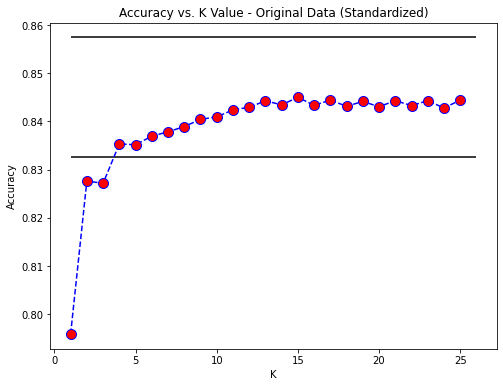

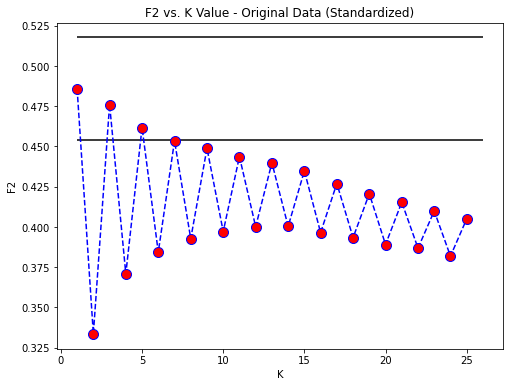

In [ ]:
## Plot k for accuracy
plt.figure(figsize = (8, 6))
plt.plot(range(1, 26), k_scores_acc, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_acc, 1, 26)
plt.hlines(upper_acc, 1, 26)
plt.title('Accuracy vs. K Value - Original Data (Standardized)')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:", round(max(k_scores_acc), 3) * 100, "at K =", int(k_scores_acc.index(max(k_scores_acc))) + 1)

## Plot k for F2 score
plt.figure(figsize = (8, 6))
plt.plot(range(1, 26), k_scores_f2, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_f2, 1, 26)
plt.hlines(upper_f2, 1, 26)
plt.title('F2 vs. K Value - Original Data (Standardized)')
plt.xlabel('K')
plt.ylabel('F2')
print("Maximum F2:", round(max(k_scores_f2), 3) * 100, "at K =", int(k_scores_f2.index(max(k_scores_f2))) + 1)

In [ ]:
## KNN Oversample Dataset
k_range = range(1, 26)
k_scores_acc = []
k_scores_f2 = []
k_scores_acc_sd = []
k_scores_f2_sd = []
# Use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn_over = KNeighborsClassifier(n_neighbors = k)
    scores = cross_validate(knn_over, X_over_scale, Y_over, cv = rcv, scoring = scoring)
    k_scores_acc.append(scores['test_accuracy'].mean())
    k_scores_f2.append(scores['test_f2'].mean())
    k_scores_acc_sd.append(scores['test_accuracy'].std())
    k_scores_f2_sd.append(scores['test_f2'].std())

In [ ]:
## Interval Accuracy
lower_acc = k_scores_acc[int(k_scores_acc.index(max(k_scores_acc)))] - k_scores_acc_sd[int(k_scores_acc.index(max(k_scores_acc)))]
upper_acc = k_scores_acc[int(k_scores_acc.index(max(k_scores_acc)))] + k_scores_acc_sd[int(k_scores_acc.index(max(k_scores_acc)))]

In [ ]:
## Interval F2
lower_f2 = k_scores_f2[int(k_scores_f2.index(max(k_scores_f2)))] - k_scores_f2_sd[int(k_scores_f2.index(max(k_scores_f2)))]
upper_f2 = k_scores_f2[int(k_scores_f2.index(max(k_scores_f2)))] + k_scores_f2_sd[int(k_scores_f2.index(max(k_scores_f2)))]

Maximum accuracy: 92.9 at K = 1
Maximum F2: 96.5 at K = 1


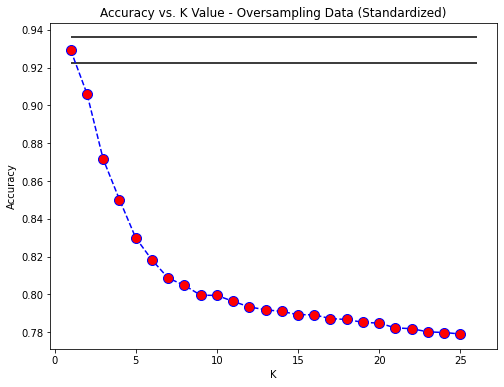

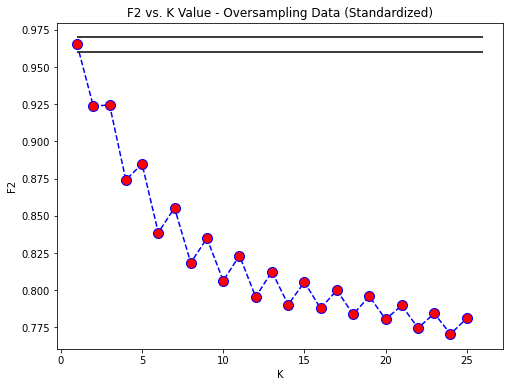

In [ ]:
# Plot k for accuracy
plt.figure(figsize = (8, 6))
plt.plot(range(1, 26), k_scores_acc, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_acc, 1, 26)
plt.hlines(upper_acc, 1, 26)
plt.title('Accuracy vs. K Value - Oversampling Data (Standardized)')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:", round(max(k_scores_acc), 3)* 100, "at K =", int(k_scores_acc.index(max(k_scores_acc))) + 1)

# Plot k for F2 score
plt.figure(figsize = (8, 6))
plt.plot(range(1, 26), k_scores_f2, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_f2, 1, 26)
plt.hlines(upper_f2, 1, 26)
plt.title('F2 vs. K Value - Oversampling Data (Standardized)')
plt.xlabel('K')
plt.ylabel('F2')
print("Maximum F2:", round(max(k_scores_f2), 3)* 100, "at K =", int(k_scores_f2.index(max(k_scores_f2))) + 1)

In [ ]:
## KNN Undersample Dataset
k_range = range(1, 26)
k_scores_acc = []
k_scores_f2 = []
k_scores_acc_sd = []
k_scores_f2_sd = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn_under = KNeighborsClassifier(n_neighbors = k)
    scores = cross_validate(knn_under, X_under_scale, Y_under, cv = rcv, scoring = scoring)
    k_scores_acc.append(scores['test_accuracy'].mean())
    k_scores_f2.append(scores['test_f2'].mean())
    k_scores_acc_sd.append(scores['test_accuracy'].std())
    k_scores_f2_sd.append(scores['test_f2'].std())

In [ ]:
## Interval Accuracy
lower_acc = k_scores_acc[int(k_scores_acc.index(max(k_scores_acc)))] - k_scores_acc_sd[int(k_scores_acc.index(max(k_scores_acc)))]
upper_acc = k_scores_acc[int(k_scores_acc.index(max(k_scores_acc)))] + k_scores_acc_sd[int(k_scores_acc.index(max(k_scores_acc)))]

In [ ]:
## Interval F2
lower_f2 = k_scores_f2[int(k_scores_f2.index(max(k_scores_f2)))] - k_scores_f2_sd[int(k_scores_f2.index(max(k_scores_f2)))]
upper_f2 = k_scores_f2[int(k_scores_f2.index(max(k_scores_f2)))] + k_scores_f2_sd[int(k_scores_f2.index(max(k_scores_f2)))]

Maximum accuracy: 0.759 at K = 21
Maximum F2: 0.742 at K = 21


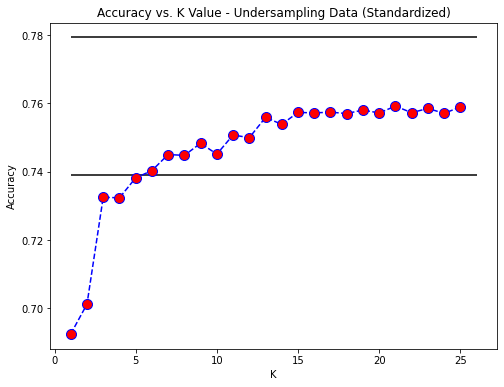

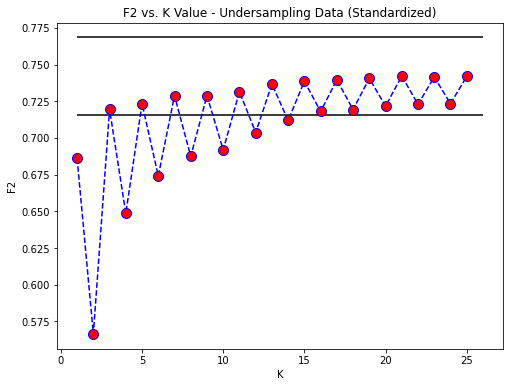

In [ ]:
# Plot k for accuracy
plt.figure(figsize = (8, 6))
plt.plot(range(1, 26), k_scores_acc, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_acc, 1, 26)
plt.hlines(upper_acc, 1, 26)
plt.title('Accuracy vs. K Value - Undersampling Data (Standardized)')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:", round(max(k_scores_acc), 3) * 100, "at K =", int(k_scores_acc.index(max(k_scores_acc))) + 1)

# Plot k for F2 score
plt.figure(figsize = (8, 6))
plt.plot(range(1, 26), k_scores_f2, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_f2, 1, 26)
plt.hlines(upper_f2, 1, 26)
plt.title('F2 vs. K Value - Undersampling Data (Standardized)')
plt.xlabel('K')
plt.ylabel('F2')
print("Maximum F2:", round(max(k_scores_f2), 3) * 100, "at K =", int(k_scores_f2.index(max(k_scores_f2))) + 1)

In [ ]:
## KNN SMOTE Dataset
k_range = range(1, 26)
k_scores_acc = []
k_scores_f2 = []
k_scores_acc_sd = []
k_scores_f2_sd = []
# Use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn_smote = KNeighborsClassifier(n_neighbors = k)
    scores = cross_validate(knn_smote, X_smote_scale, Y_smote, cv = rcv, scoring = scoring)
    k_scores_acc.append(scores['test_accuracy'].mean())
    k_scores_f2.append(scores['test_f2'].mean())
    k_scores_acc_sd.append(scores['test_accuracy'].std())
    k_scores_f2_sd.append(scores['test_f2'].std())

In [ ]:
## Interval Accuracy
lower_acc = k_scores_acc[int(k_scores_acc.index(max(k_scores_acc)))] - k_scores_acc_sd[int(k_scores_acc.index(max(k_scores_acc)))]
upper_acc = k_scores_acc[int(k_scores_acc.index(max(k_scores_acc)))] + k_scores_acc_sd[int(k_scores_acc.index(max(k_scores_acc)))]

In [ ]:
## Interval F2
lower_f2 = k_scores_f2[int(k_scores_f2.index(max(k_scores_f2)))] - k_scores_f2_sd[int(k_scores_f2.index(max(k_scores_f2)))]
upper_f2 = k_scores_f2[int(k_scores_f2.index(max(k_scores_f2)))] + k_scores_f2_sd[int(k_scores_f2.index(max(k_scores_f2)))]

Maximum accuracy: 87.0 at K = 10
Maximum F2: 87.2 at K = 1


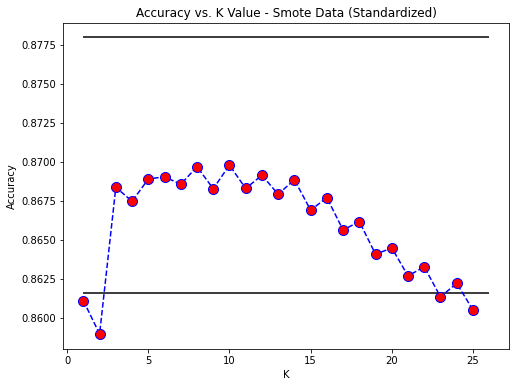

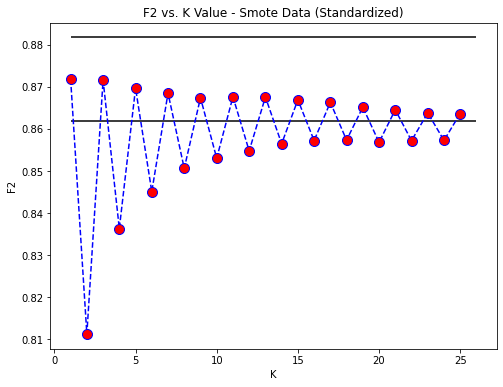

In [ ]:
# Plot k for accuracy
plt.figure(figsize = (8, 6))
plt.plot(range(1, 26), k_scores_acc, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_acc, 1, 26)
plt.hlines(upper_acc, 1, 26)
plt.title('Accuracy vs. K Value - Smote Data (Standardized)')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:", round(max(k_scores_acc), 3) * 100, "at K =", int(k_scores_acc.index(max(k_scores_acc))) + 1)

# Plot k for F2 score
plt.figure(figsize = (8, 6))
plt.plot(range(1, 26), k_scores_f2, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_f2, 1, 26)
plt.hlines(upper_f2, 1, 26)
plt.title('F2 vs. K Value - Smote Data (Standardized)')
plt.xlabel('K')
plt.ylabel('F2')
print("Maximum F2:", round(max(k_scores_f2), 3) * 100, "at K =", int(k_scores_f2.index(max(k_scores_f2))) + 1)

### SVM

In [ ]:
## Original Dataset
c_range = [0.1, 1, 10]
c_scores_acc = []
c_scores_f2 = []
c_scores_acc_sd = []
c_scores_f2_sd = []
# Use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for c in c_range:
    svm_original = svm.SVC(C = c)
    scores = cross_validate(svm_original, X_scale, y_train, cv = rcv, scoring = scoring)
    c_scores_acc.append(scores['test_accuracy'].mean())
    c_scores_f2.append(scores['test_f2'].mean())
    c_scores_acc_sd.append(scores['test_accuracy'].std())
    c_scores_f2_sd.append(scores['test_f2'].std())

In [ ]:
## Interval Accuracy
lower_acc = c_scores_acc[int(c_scores_acc.index(max(c_scores_acc)))] - c_scores_acc_sd[int(c_scores_acc.index(max(c_scores_acc)))]
upper_acc = c_scores_acc[int(c_scores_acc.index(max(c_scores_acc)))] + c_scores_acc_sd[int(c_scores_acc.index(max(c_scores_acc)))]

In [ ]:
## Interval F2
lower_f2 = c_scores_f2[int(c_scores_f2.index(max(c_scores_f2)))] - c_scores_f2_sd[int(c_scores_f2.index(max(c_scores_f2)))]
upper_f2 = c_scores_f2[int(c_scores_f2.index(max(c_scores_f2)))] + c_scores_f2_sd[int(c_scores_f2.index(max(c_scores_f2)))]

Maximum accuracy: 86.0 at C = 3
Maximum F2: 49.7 at C = 3


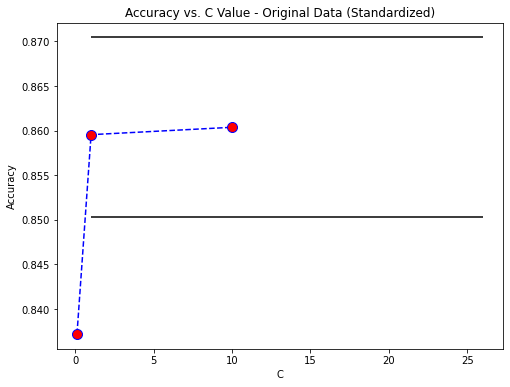

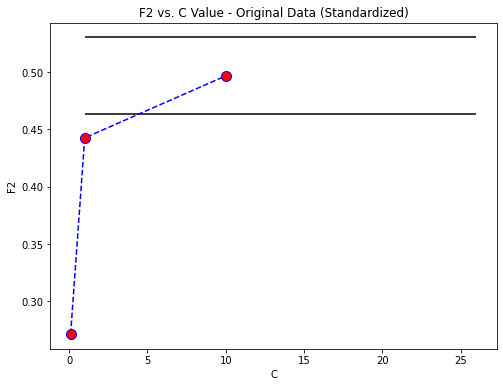

In [ ]:
# Plot k for accuracy
plt.figure(figsize = (8, 6))
plt.plot(c_range, c_scores_acc, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_acc, 1, 26)
plt.hlines(upper_acc, 1, 26)
plt.title('Accuracy vs. C Value - Original Data (Standardized)')
plt.xlabel('C')
plt.ylabel('Accuracy')
print("Maximum accuracy:", round(max(c_scores_acc), 3) * 100, "at C =", int(c_scores_acc.index(max(c_scores_acc))) + 1)

# Plot k for F2 score
plt.figure(figsize = (8, 6))
plt.plot(, c_scores_f2, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_f2, 1, 26)
plt.hlines(upper_f2, 1, 26)
plt.title('F2 vs. C Value - Original Data (Standardized)')
plt.xlabel('C')
plt.ylabel('F2')
print("Maximum F2:", round(max(c_scores_f2), 3) * 100, "at C =", int(c_scores_f2.index(max(c_scores_f2))) + 1)

In these plots and the following ones you can see  C = 3 but this is not the real value in fact it indicates the third value in the list that is 10

In [ ]:
## Oversampling Dataset
c_range = [0.1, 1, 10]
c_scores_acc = []
c_scores_f2 = []
c_scores_acc_sd = []
c_scores_f2_sd = []
# Use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for c in c_range:
    svm_original = svm.SVC(C = c)
    scores = cross_validate(svm_original, X_over_scale, Y_over, cv = rcv, scoring = scoring)
    c_scores_acc.append(scores['test_accuracy'].mean())
    c_scores_f2.append(scores['test_f2'].mean())
    c_scores_acc_sd.append(scores['test_accuracy'].std())
    c_scores_f2_sd.append(scores['test_f2'].std())

In [ ]:
## Interval Accuracy
lower_acc = c_scores_acc[int(c_scores_acc.index(max(c_scores_acc)))] - c_scores_acc_sd[int(c_scores_acc.index(max(c_scores_acc)))]
upper_acc = c_scores_acc[int(c_scores_acc.index(max(c_scores_acc)))] + c_scores_acc_sd[int(c_scores_acc.index(max(c_scores_acc)))]

In [ ]:
## Interval F2
lower_f2 = c_scores_f2[int(c_scores_f2.index(max(c_scores_f2)))] - c_scores_f2_sd[int(c_scores_f2.index(max(c_scores_f2)))]
upper_f2 = c_scores_f2[int(c_scores_f2.index(max(c_scores_f2)))] + c_scores_f2_sd[int(c_scores_f2.index(max(c_scores_f2)))]

Maximum accuracy: 83.0 at C = 3
Maximum F2: 83.8 at C = 3


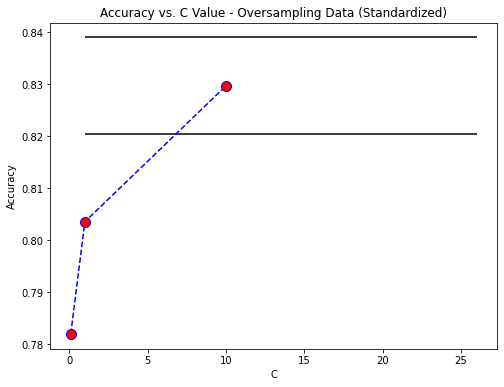

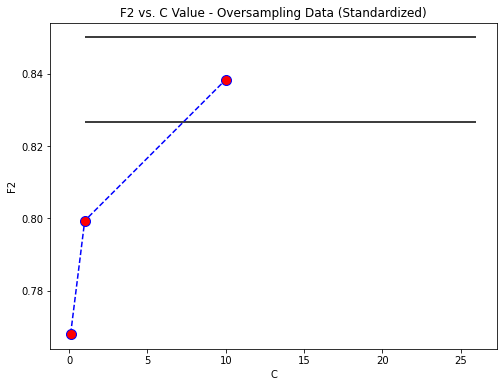

In [ ]:
# Plot k for accuracy
plt.figure(figsize = (8, 6))
plt.plot(c_range, c_scores_acc, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_acc, 1, 26)
plt.hlines(upper_acc, 1, 26)
plt.title('Accuracy vs. C Value - Oversampling Data (Standardized)')
plt.xlabel('C')
plt.ylabel('Accuracy')
print("Maximum accuracy:", round(max(c_scores_acc), 3) * 100, "at C =", int(c_scores_acc.index(max(c_scores_acc))) + 1)

# Plot k for F2 score
plt.figure(figsize = (8, 6))
plt.plot(c_range, c_scores_f2, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_f2, 1, 26)
plt.hlines(upper_f2, 1, 26)
plt.title('F2 vs. C Value - Oversampling Data (Standardized)')
plt.xlabel('C')
plt.ylabel('F2')
print("Maximum F2:", round(max(c_scores_f2), 3) * 100, "at C =", int(c_scores_f2.index(max(c_scores_f2))) + 1)

In [ ]:
## Undersampling Dataset
c_range = [0.1, 1, 10]
c_scores_acc = []
c_scores_f2 = []
c_scores_acc_sd = []
c_scores_f2_sd = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for c in c_range:
    svm_original = svm.SVC(C = c)
    scores = cross_validate(svm_original, X_under_scale, Y_under, cv = rcv, scoring = scoring)
    c_scores_acc.append(scores['test_accuracy'].mean())
    c_scores_f2.append(scores['test_f2'].mean())
    c_scores_acc_sd.append(scores['test_accuracy'].std())
    c_scores_f2_sd.append(scores['test_f2'].std())

In [ ]:
## Interval Accuracy
lower_acc = c_scores_acc[int(c_scores_acc.index(max(c_scores_acc)))] - c_scores_acc_sd[int(c_scores_acc.index(max(c_scores_acc)))]
upper_acc = c_scores_acc[int(c_scores_acc.index(max(c_scores_acc)))] + c_scores_acc_sd[int(c_scores_acc.index(max(c_scores_acc)))]

In [ ]:
## Interval F2
lower_f2 = c_scores_f2[int(c_scores_f2.index(max(c_scores_f2)))] - c_scores_f2_sd[int(c_scores_f2.index(max(c_scores_f2)))]
upper_f2 = c_scores_f2[int(c_scores_f2.index(max(c_scores_f2)))] + c_scores_f2_sd[int(c_scores_f2.index(max(c_scores_f2)))]

Maximum accuracy: 77.9 at C = 2
Maximum F2: 76.5 at C = 2


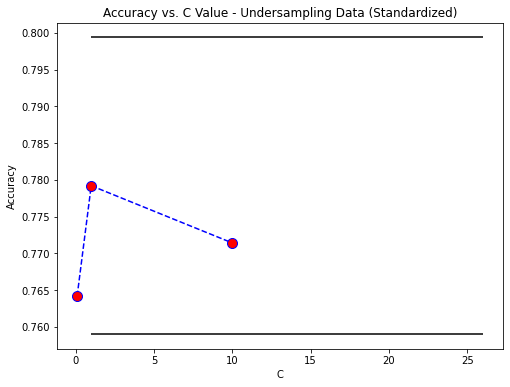

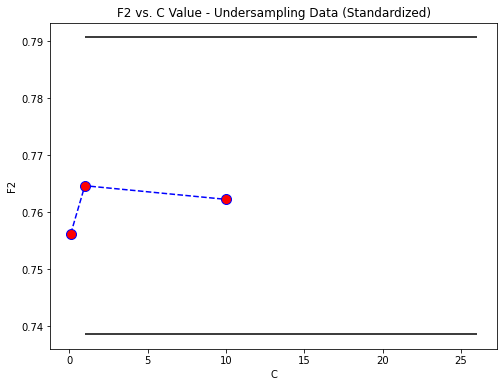

In [ ]:
# Plot k for accuracy
plt.figure(figsize = (8, 6))
plt.plot(c_range, c_scores_acc, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_acc, 1, 26)
plt.hlines(upper_acc, 1, 26)
plt.title('Accuracy vs. C Value - Undersampling Data (Standardized)')
plt.xlabel('C')
plt.ylabel('Accuracy')
print("Maximum accuracy:", round(max(c_scores_acc), 3) * 100, "at C =", int(c_scores_acc.index(max(c_scores_acc))) + 1)

# Plot k for F2 score
plt.figure(figsize = (8, 6))
plt.plot(c_range, c_scores_f2, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_f2, 1, 26)
plt.hlines(upper_f2, 1, 26)
plt.title('F2 vs. C Value - Undersampling Data (Standardized)')
plt.xlabel('C')
plt.ylabel('F2')
print("Maximum F2:", round(max(c_scores_f2), 3) * 100, "at C =", int(c_scores_f2.index(max(c_scores_f2))) + 1)

In [ ]:
## SMOTE Dataset
c_range = [0.1, 1, 10]
c_scores_acc = []
c_scores_f2 = []
c_scores_acc_sd = []
c_scores_f2_sd = []
# Use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for c in c_range:
    svm_original = svm.SVC(C = c)
    scores = cross_validate(svm_original, X_smote_scale, Y_smote, cv = rcv, scoring = scoring)
    c_scores_acc.append(scores['test_accuracy'].mean())
    c_scores_f2.append(scores['test_f2'].mean())
    c_scores_acc_sd.append(scores['test_accuracy'].std())
    c_scores_f2_sd.append(scores['test_f2'].std())

In [ ]:
## Interval Accuracy
lower_acc = c_scores_acc[int(c_scores_acc.index(max(c_scores_acc)))] - c_scores_acc_sd[int(c_scores_acc.index(max(c_scores_acc)))]
upper_acc = c_scores_acc[int(c_scores_acc.index(max(c_scores_acc)))] + c_scores_acc_sd[int(c_scores_acc.index(max(c_scores_acc)))]

In [ ]:
## Interval F2
lower_f2 = c_scores_f2[int(c_scores_f2.index(max(c_scores_f2)))] - c_scores_f2_sd[int(c_scores_f2.index(max(c_scores_f2)))]
upper_f2 = c_scores_f2[int(c_scores_f2.index(max(c_scores_f2)))] + c_scores_f2_sd[int(c_scores_f2.index(max(c_scores_f2)))]

Maximum accuracy: 88.7 at C = 3
Maximum F2: 86.2 at C = 3


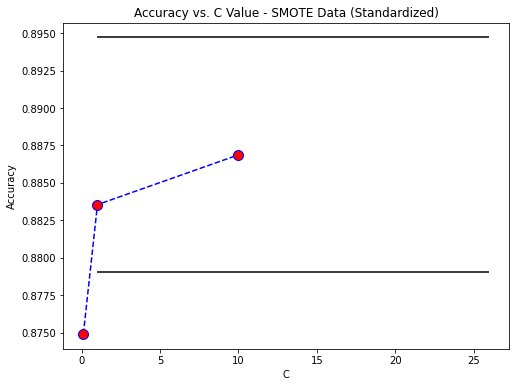

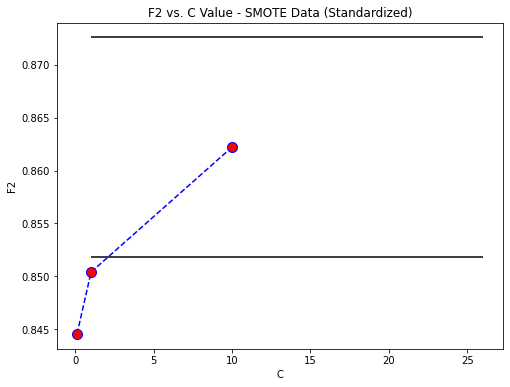

In [ ]:
# Plot k for accuracy
plt.figure(figsize = (8, 6))
plt.plot(c_range, c_scores_acc, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_acc, 1, 26)
plt.hlines(upper_acc, 1, 26)
plt.title('Accuracy vs. C Value - SMOTE Data (Standardized)')
plt.xlabel('C')
plt.ylabel('Accuracy')
print("Maximum accuracy:", round(max(c_scores_acc), 3) * 100, "at C =", int(c_scores_acc.index(max(c_scores_acc))) + 1)

# Plot k for F2 score
plt.figure(figsize = (8, 6))
plt.plot(c_range, c_scores_f2, color = 'blue', linestyle = 'dashed', 
         marker = 'o',markerfacecolor = 'red', markersize = 10)
plt.hlines(lower_f2, 1, 26)
plt.hlines(upper_f2, 1, 26)
plt.title('F2 vs. C Value - SMOTE Data (Standardized)')
plt.xlabel('C')
plt.ylabel('F2')
print("Maximum F2:", round(max(c_scores_f2), 3) * 100, "at C =", int(c_scores_f2.index(max(c_scores_f2))) + 1)

## Test Performance on External Set

We chose the dataset on which each model performs better in cross validation and than we re-train (without cross validation) each model on the same dataset and then we make prediction on the external set

In [ ]:
def metrics(y_validation, y_pred):
    ''' It computes and returns the metrics we are interested in  '''
  ## Confusion Matric
  matrix = confusion_matrix(y_validation, y_pred, labels = [1,0])
  ## Other metrics
  acc = round(accuracy_score(y_validation, y_pred), 3)
  f2 = round(fbeta_score(y_validation, y_pred, beta = 2), 3)
  auc = round(roc_auc_score(y_validation, y_pred), 3)
  sens = round(matrix[0,0]/(matrix[0,0]+matrix[0,1]), 3)
  spec = round(matrix[1,1]/(matrix[1,0]+matrix[1,1]), 3)

  results = pd.DataFrame({'Accuracy':[acc], 'F2-Score':[f2], 'AUC':[auc], 'Sensitivity':[sens], 'Specificity':[spec]})
  return results

In [ ]:
## Initialize dataset in which we will store the models performances
performance = pd.DataFrame()

In [ ]:
## External set standardization
x_validation_scale = mkstds(x_validation)

In [ ]:
## Logistic Regression (Best Model: SMOTE)

## Fit
model_logit_smote_validation = model_logit_smote.fit(X_smote_scale, Y_smote)
## Predict
y_pred_logit = model_logit_smote.predict(x_validation_scale)

Confusion matrix : 
 [[ 93 126]
 [ 98 683]]


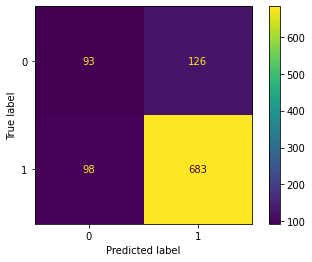

In [ ]:
## Results
## confusion matrix
matrix = confusion_matrix(y_validation, y_pred_logit, labels=[1,0])

performance = pd.concat([performance, (metrics(y_validation, y_pred_logit))])

## Plot
disp = ConfusionMatrixDisplay(confusion_matrix = matrix)
disp.plot()
plt.show()

In [ ]:
## KNN (Best Model: 'SMOTE', k = '11')

## Init 
knn_smote_validation = KNeighborsClassifier(n_neighbors = 11)
## Fit
knn_smote_validation = knn_smote_validation.fit(X_smote_scale, Y_smote)
## Predict
knn_pred = knn_smote_validation.predict(x_validation_scale)

Confusion matrix : 
 [[146  73]
 [109 672]]


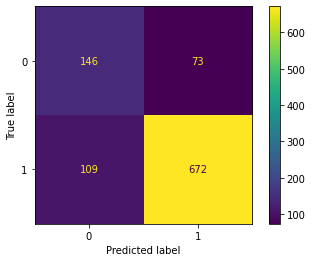

In [ ]:
## Results
## confusion matrix
matrix = confusion_matrix(y_validation, knn_pred, labels=[1,0])

performance = pd.concat([performance, (metrics(y_validation, knn_pred))])

## Plot
disp = ConfusionMatrixDisplay(confusion_matrix = matrix)
disp.plot()
plt.show()

In [ ]:
## SVM (Best Model: 'SMOTE', C = 10)

## Init 
svm_smote_validation = svm.SVC(C=10)
## Fit
svm_smote_validation = svm_smote_validation.fit(X_smote_scale, Y_smote)
## Predict
svm_pred = svm_smote_validation.predict(x_validation_scale)

Confusion matrix : 
 [[131  88]
 [ 92 689]]


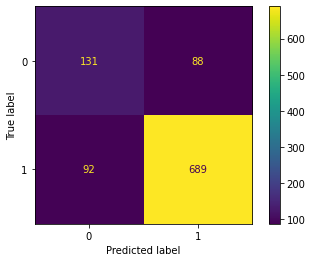

In [ ]:
## Results
## confusion matrix
matrix = confusion_matrix(y_validation, svm_pred, labels=[1,0])

performance = pd.concat([performance, (metrics(y_validation, svm_pred))])

## Plot
disp = ConfusionMatrixDisplay(confusion_matrix = matrix)
disp.plot()
plt.show()

In [ ]:
## Summary
performance.index = ['Logistic Regression', 'K-Nearest Neighbors', 'Support Vector Machine']
performance

,Accuracy,F2-Score,AUC,Sensitivity,Specificity
Logistic Regression,0.776,0.436,0.650,0.425,0.875
K-Nearest Neighbors,0.818,0.645,0.764,0.667,0.860
Support Vector Machine,0.820,0.596,0.740,0.598,0.882


Here we can consider achieved the goals we had set for our project, but due to the not very high performance we thought to use an ensemble model taking into account the literature we revised: Random Forest...

### Random Forest

In this section we do hyperparameters tuning with cross validation in order to obtain the best parameters (with a randomized search) of the model for the different datasets 

In [ ]:
## Tuning Parameters

## Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
## Number of features to consider at every split
max_features = ['auto', 'sqrt']
## Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
## Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30]
## Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
## Method of selecting samples for training each tree
bootstrap = [True, False]
## Criterion
criterion = ['gini', 'entropy']

## To perform a random grid search, so we define a range of values from which the code can randomly pick and 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [ ]:
## New Repeated CV
rcv2 = RepeatedKFold(n_splits = 10, n_repeats = 20, random_state = 1)

In [ ]:
## Score
scoring = {'f2': make_scorer(fbeta_score, beta=2), 'accuracy': 'accuracy'}

In [ ]:
## K-Fold Cross Validation
rf_original = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_original,
                               param_distributions = random_grid,
                               cv = rcv2, scoring = scoring, refit = 'f2')

In [ ]:
## Fit Original Data
rf_original = rf_random.fit(X_scale, y_train)

In [ ]:
## View the parameter values he random search found:
rf_original.best_params_

{'n_estimators': 1964,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'criterion': 'entropy',
 'bootstrap': False}

In [ ]:
## Results
rf_original.best_score_

0.5065474435505665

In [ ]:
## Fit Oversampling Data
rf_over = rf_random.fit(X_over_scale, Y_over)

In [ ]:
## View the parameter values he random search found:
rf_over.best_params_

{'n_estimators': 1964,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': False}

In [ ]:
## Results
rf_over.best_score_

0.9643666877459083

In [ ]:
## Fit Undersampling Data
rf_under = rf_random.fit(X_under_scale, Y_under)

In [ ]:
## View the parameter values he random search found:
rf_under.best_params_

{'n_estimators': 514,
 'min_samples_split': 20,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'criterion': 'gini',
 'bootstrap': True}

In [ ]:
## Results
rf_under.best_score_

0.7706380624156681

In [ ]:
## Fit SMOTE Data
rf_smote = rf_random.fit(X_smote_scale, Y_smote)

In [ ]:
## View the parameter values he random search found:
rf_smote.best_params_

{'n_estimators': 928,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 50,
 'criterion': 'gini',
 'bootstrap': False}

In [ ]:
## Results
rf_smote.best_score_

0.8745681543284993

### Test on External Validation

In [ ]:
performance = pd.DataFrame()

In [ ]:
## Best parameters (Undersampling)
best_parameters = {'n_estimators': 514,
 'min_samples_split': 20,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'criterion': 'gini',
 'bootstrap': True}

In [ ]:
## Standardization
x_validation_scale = mkstds(x_validation)

In [ ]:
## Test Random Forest on external

## Init 
rf_validation = RandomForestClassifier(n_estimators = 514, min_samples_split = 20, min_samples_leaf = 4, max_features = 'auto',
                                       max_depth = 100, criterion = 'gini', bootstrap = True)

## Fit
rf_validation.fit(X_under_scale, Y_under)

## Predict
rf_pred = rf_validation.predict(x_validation_scale)

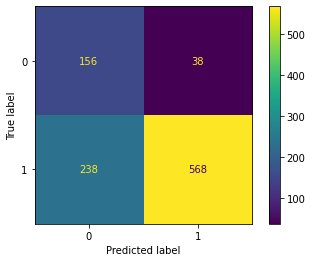

In [ ]:
## Results
## confusion matrix
matrix = confusion_matrix(y_validation, rf_pred, labels=[1,0])

## Plot
disp = ConfusionMatrixDisplay(confusion_matrix = matrix)
disp.plot()
plt.show()

In [ ]:
## Check
performance_rf_external = pd.concat([performance, (metrics(y_validation, rf_pred))])
performance_rf_external

,Accuracy,F2-Score,AUC,Sensitivity,Specificity
0,0.724,0.667,0.754,0.804,0.705
